In [15]:
# parameters
config_dir = "../experiments"
exp_name = "014_output_viz/base_v4"

In [16]:
%cd /kaggle/working

from pathlib import Path

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path=f"{config_dir}/{exp_name.split('/')[0]}"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=[f"exp={exp_name.split('/')[-1]}"],
        return_hydra_config=True,
    )
import pickle

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

# 定数定義
output_dir = Path(f"output/experiments/{exp_name}")
gcs_path = f"gs://{cfg.dir.gcs_bucket}/{cfg.dir.gcs_base_dir}/experiments/{exp_name}/"

# カラムの定義
single_targets = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]
seq_targets = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]
target_columns = []
for col in seq_targets:
    for i in range(60):
        target_columns.append(f"{col}_{i}")
target_columns.extend(single_targets)


# 結果などの読み込み
r2_score_dict = pickle.load(open(output_dir / "r2_score_dict.pkl", "rb"))
print("read predict")
predict_df = pl.read_parquet(gcs_path + "predict.parquet", retries=5)
print("read label")
label_df = pl.read_parquet(gcs_path + "label.parquet", retries=5)
ss_df = pl.read_csv(
    "input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", n_rows=1
)
weight_array = ss_df.select([x for x in ss_df.columns if x != "sample_id"]).to_numpy()[
    0
]

/kaggle/working
read predict
read label


## 全体概要

In [17]:
print("r2: ", np.mean(list(r2_score_dict.values())))

r2:  0.5861639204146082


## sequential target

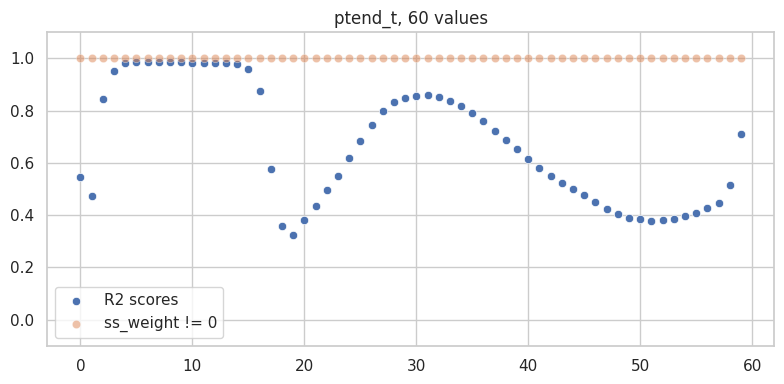

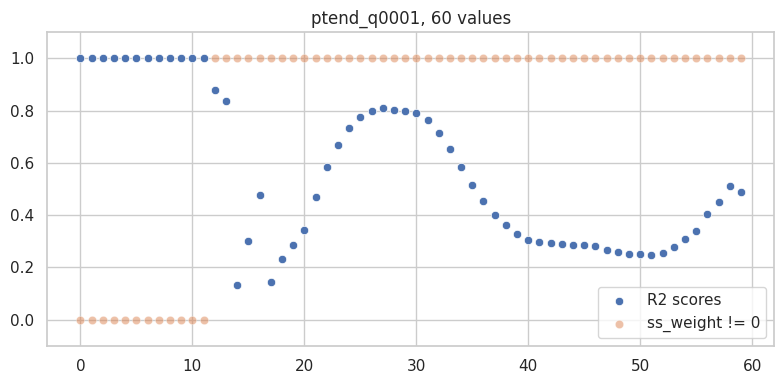

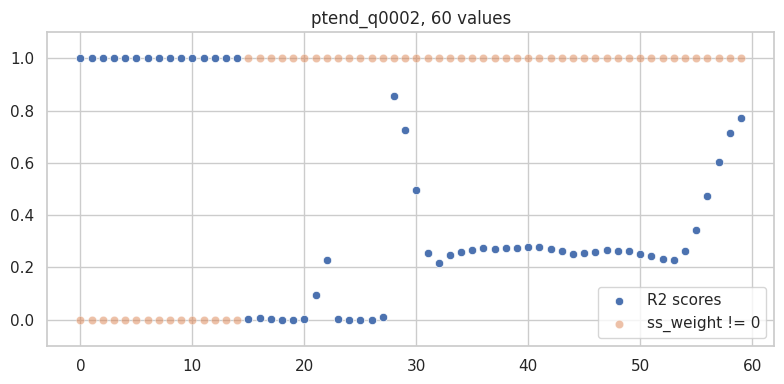

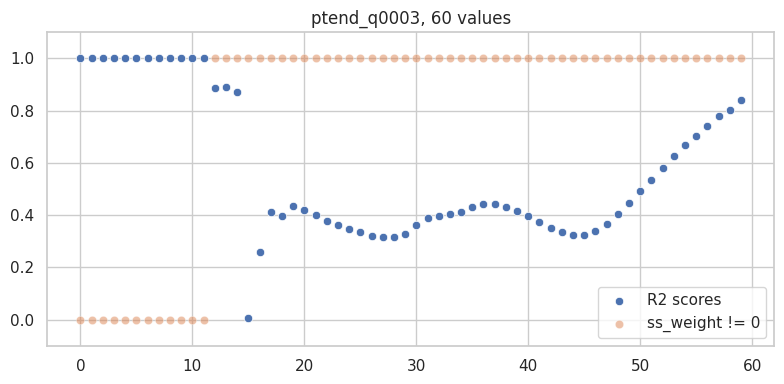

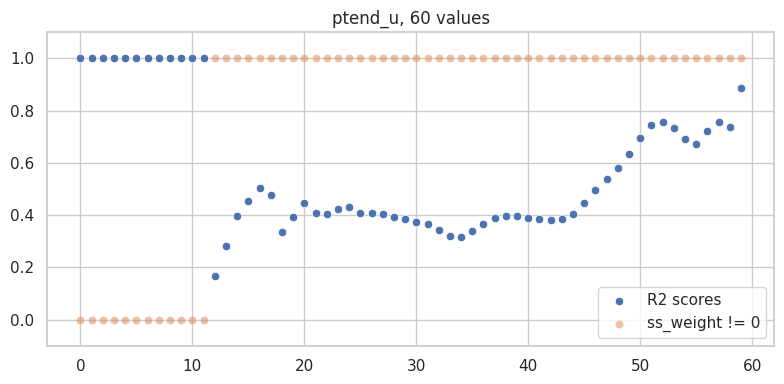

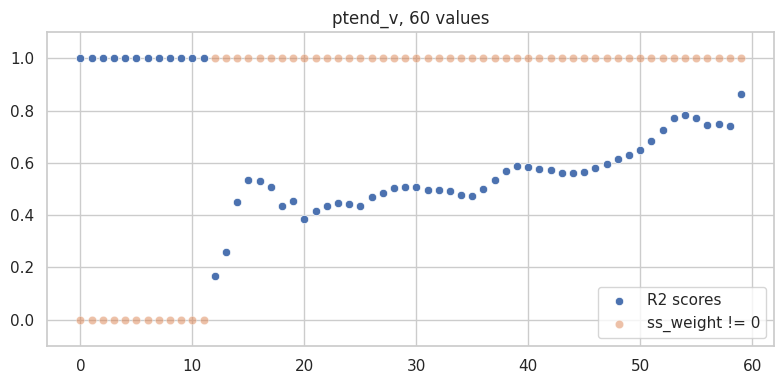

In [18]:
for col in seq_targets:
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.scatterplot(
        x=range(60),
        y=[r2_score_dict[f"{col}_{i}"] for i in range(60)],
        label="R2 scores",
        ax=ax,
    )
    sns.scatterplot(
        x=range(60),
        y=[(ss_df[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)],
        alpha=0.5,
        label="ss_weight != 0",
        ax=ax,
    )

    ax.set_title(f"{col}, 60 values")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

    plt.tight_layout()
    plt.show()

## single target

cam_out_NETSW : 0.9810225055989599
cam_out_FLWDS : 0.9837158202491332
cam_out_PRECSC : 0.8897261265000618
cam_out_PRECC : 0.8617963081768103
cam_out_SOLS : 0.9706148031235469
cam_out_SOLL : 0.9592890438627777
cam_out_SOLSD : 0.9526047138119336
cam_out_SOLLD : 0.8769312092978604


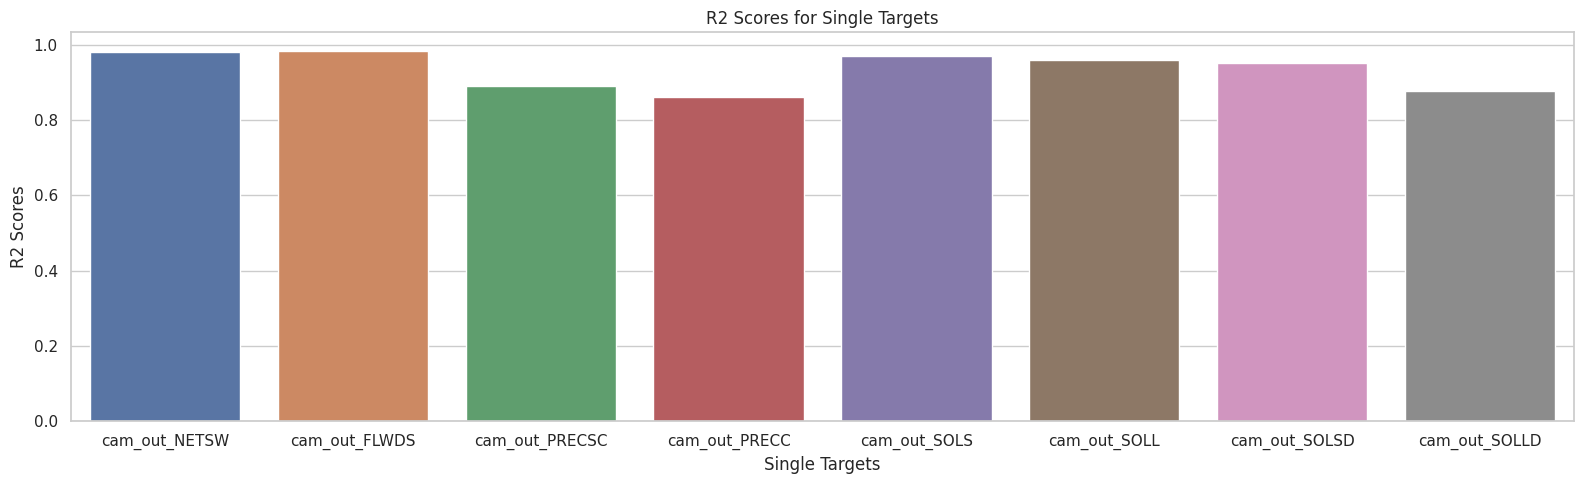

In [19]:
# single scaler target
plt.figure(figsize=(16, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=np.array(single_targets),
    y=np.array([r2_score_dict[col] for col in single_targets]),
)

plt.xlabel("Single Targets")
plt.ylabel("R2 Scores")
plt.title("R2 Scores for Single Targets")

for col in single_targets:
    print(f"{col} : {r2_score_dict[col]}")

plt.tight_layout()
plt.show()

## マイナスが大きいターゲットについて確認

In [20]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / "y_nanmean.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / "y_rms_sub.npy")
y_lower_bound = np.load(Path(cfg.exp.scale_dir) / "y_lower_bound.npy")
y_upper_bound = np.load(Path(cfg.exp.scale_dir) / "y_upper_bound.npy")


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.01:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(f"{y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}")
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_q0002_15 】
r2_score=0.001672
ri=776227, ci=135
preds[ri,ci]=-1.1601e-53, labels[ri,ci]=-2.0366e-50
mse[ri]=4.1431e-100, r2: 1-(mse.mean()=2.9534e-106)/(base.mean()=2.9583e-106)
y_nanmean[ci]=-4.8875e-57, y_lower_bound[ci]=-4.7757e-52, y_upper_bound[ci]=2.3879e-52
preds[:,ci].mean()=-2.0249e-57, preds[:,ci].min()=-2.0451e-53, preds[:,ci].max()=1.2374e-54
labels[:,ci].mean()=-2.0768e-56, labels[:,ci].min()=-2.0366e-50, labels[:,ci].max()=0

【 ptend_q0002_16 】
r2_score=0.006815
ri=911843, ci=136
preds[ri,ci]=-4.3486e-49, labels[ri,ci]=-3.5408e-46
mse[ri]=1.2506e-91, r2: 1-(mse.mean()=1.2952e-97)/(base.mean()=1.3041e-97)
y_nanmean[ci]=-1.4126e-53, y_lower_bound[ci]=-5.0164e-48, y_upper_bound[ci]=2.5082e-48
preds[:,ci].mean()=2.8826e-54, preds[:,ci].min()=-1.2284e-48, preds[:,ci].max()=6.9535e-50
labels[:,ci].mean()=-6.1453e-52, labels[:,ci].min()=-3.5408e-46, labels[:,ci].max()=0

【 ptend_q0002_17 】
r2_score=0.0016682
ri=911842, ci=137
preds[ri,ci]=-4.8059e-45, labels[ri,ci]=-1.722

## 値が大きくないやつ

In [21]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / "y_nanmean.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / "y_rms_sub.npy")
y_lower_bound = np.load(Path(cfg.exp.scale_dir) / "y_lower_bound.npy")
y_upper_bound = np.load(Path(cfg.exp.scale_dir) / "y_upper_bound.npy")


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.5:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(f"{y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}")
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_t_1 】
r2_score=0.47464
ri=901163, ci=1
preds[ri,ci]=0.00012451, labels[ri,ci]=0.020611
mse[ri]=0.00041969, r2: 1-(mse.mean()=1.7699e-09)/(base.mean()=3.3689e-09)
y_nanmean[ci]=-7.0439e-06, y_lower_bound[ci]=-0.0040036, y_upper_bound[ci]=0.0044428
preds[:,ci].mean()=-7.6981e-06, preds[:,ci].min()=-0.00044825, preds[:,ci].max()=0.00014584
labels[:,ci].mean()=-7.3538e-06, labels[:,ci].min()=-0.0036464, labels[:,ci].max()=0.020611

【 ptend_t_18 】
r2_score=0.35876
ri=1426257, ci=18
preds[ri,ci]=-0.00036756, labels[ri,ci]=-0.0017031
mse[ri]=1.7837e-06, r2: 1-(mse.mean()=7.7489e-11)/(base.mean()=1.2084e-10)
y_nanmean[ci]=7.6027e-07, y_lower_bound[ci]=-0.0016539, y_upper_bound[ci]=0.0013551
preds[:,ci].mean()=9.7684e-07, preds[:,ci].min()=-0.00045352, preds[:,ci].max()=0.00037752
labels[:,ci].mean()=7.9682e-07, labels[:,ci].min()=-0.0017031, labels[:,ci].max()=0.00079439

【 ptend_t_19 】
r2_score=0.32479
ri=903804, ci=19
preds[ri,ci]=-7.4819e-05, labels[ri,ci]=-0.0015712
mse[ri]=2.2391e